# AML 2023/2024 Egocentric Vision Project

#Setup

In [ ]:
# Installing missing dependencies
!pip install omegaconf coloredlogs wandb

##Download code

In [ ]:
#Clone from another repo
!rm -r aml23-ego
!git clone https://github.com/LeleFox/Multimodal-Egocentric-Action-Recognition-2024.git aml23-ego

In [1]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


# Epic-Kitchen dataset

##Load Data


In [ ]:
%%bash

#8 mins
# As read and write operations from google drive are slow, we suggest to copy and unzip
# the dataset in a local directory on the Colab's machine.
mkdir -p ek_data/frames

# Copy the *.zip files of Epic-Kitchens
cp /content/drive/MyDrive/AML/AML_Project_2024/data/Epic_Kitchens_reduced/*.zip ./ek_data

# Unzip
for file in ./ek_data/*.zip; do
  fn=$(basename $file)
  fn=${fn/.zip/}
  ls -lah $file
  mkdir -p ek_data/frames/$fn
  unzip -q -j $file -d ek_data/frames/$fn
done

In [ ]:
#save in Mydrive the trained network
!cp "aml23-ego/saved_models/MLP_3layers_5clips_16frames_dense_04dropout_NormalizeFalse_FeaturesAverage" -r "/content/drive/MyDrive/AML/AML_Project_2024/saved_models/Epic-Kitchen/"

## Features extraction

In [ ]:
%%bash

cd aml23-ego

python save_feat.py \
  name=saved_feat_I3D_10clips_25frames_Uniform_05dropout_NormalizeFalse \
  config=configs/I3D_save_feat.yaml \
  split=train\
  dataset.annotations_path=train_val\
  dataset.RGB.features_name=saved_feat_I3D_5_D1_test.pkl\
  resume_from=/content/drive/MyDrive/AML/AML_Project_2024/saved_models/I3D_SourceOnlyD1 \
  save.num_clips=10 \
  save.num_frames_per_clip.RGB=25 \
  save.dense_sampling.RGB=False\
  dataset.shift=D1-D1 \
  dataset.RGB.data_path=../ek_data/frames\
  models.RGB.dropout=0.5 \
  models.RGB.normalize=False\

In [ ]:
#!ls aml23-ego/saved_features
!cp "aml23-ego/saved_features/saved_feat_I3D_10clips_25frames_Uniform_05dropout_NormalizeFalse_D1_train.pkl" -r "/content/drive/MyDrive/AML/AML_Project_2024/saved_features/Epic-Kitchen_RGB/mine/"

##Features Statistics: 2D plot of features

In [ ]:
%%bash

cd aml23-ego

python Feature_stats.py\
  config=configs/I3D_save_feat.yaml\
  name=showing_features_in_2D_space\
  split=test\
  feat_avg=False\
  resume_from=/content/drive/MyDrive/AML/AML_Project_2024/saved_models/I3D_SourceOnlyD1\
  save.num_clips=10\
  save.dense_sampling.RGB=True\
  save.num_frames_per_clip.RGB=25\
  dataset.shift=D1-D1\
  dataset.RGB.data_path=../ek_data/frames\
  dataset.annotations_path=train_val\
  dataset.RGB.features_name=/content/drive/MyDrive/AML/AML_Project_2024/saved_features/Epic-Kitchen_RGB/saved_feat_I3D_5clips_16frames_dense_05dropout_NormalizeFalse\
  models.RGB.dropout=0.5 \
  models.RGB.normalize=False\

##EPIC-KITCHEN-Classifiers



We run:

From now on change the configuration file from args.py from "I3D_save_feat.yaml" to "default.yaml":

args = OmegaConf.load(os.path.join(conf_path, "default.yaml"))

In [ ]:
%%bash

cd aml23-ego

python train_classifier.py\
  config=configs/default.yaml\
  action=train\
  name=LSTM_1layers_5clips_16frames_dense_04dropout_NormalizeFalse_LogitsAverage\
  modality="['RGB']"\
  feat_avg=False\
  train.num_clips=5\
  train.dense_sampling.RGB=True\
  train.dense_sampling.EMG=True\
  train.num_frames_per_clip.RGB=16\
  train.num_frames_per_clip.EMG=16\
  test.num_clips=5\
  test.dense_sampling.RGB=True\
  test.dense_sampling.EMG=True\
  test.num_frames_per_clip.RGB=16\
  test.num_frames_per_clip.EMG=16\
  dataset.annotations_path=train_val\
  dataset.shift=D1-D1\
  dataset.RGB.features_name=/content/drive/MyDrive/AML/AML_Project_2024/saved_features/Epic-Kitchen_RGB/saved_feat_I3D_5clips_16frames_dense_05dropout_NormalizeFalse\
  dataset.RGB.data_path=../ek_data/frames\
  dataset.EMG.features_name=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  dataset.EMG.data_path=True\
  models.RGB.model=MLP\
  models.RGB.dropout=0.4\
  models.RGB.normalize=False\
  models.EMG.model=LSTM_EMG\
  models.EMG.dropout=0.4\
  models.EMG.normalize=False\
  models.FUSION.model=FUSION_net\
  models.FUSION.dropout=0.2\
  models.FUSION.normalize=False\
  fusion_modalities:False\

In [ ]:
#save in Mydrive the trained network
!cp "aml23-ego/saved_models/LSTM_1layers_5clips_16frames_dense_04dropout_NormalizeFalse_LogitsAverage/Feb23_20-25-35" -r "/content/drive/MyDrive/AML/AML_Project_2024/saved_models/Epic-Kitchen/"

#Action-NET


##Preprocess EMG data

In [ ]:
%%bash

cd aml23-ego

python action-net/Action-Net_process_data.py\

##Extract features for subject S04 RGB flow

###Load frames

In [ ]:
%%bash

mkdir -p Action_Net/

# Copy the files of Action-Net
cp /content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/Action-Net-RGB/*.zip ./Action_Net

# Unzip
for file in ./Action_Net/*.zip; do
  fn=$(basename $file)
  fn=${fn/.zip/}
  ls -lah $file
  mkdir -p Action_Net/frames/$fn
  unzip -q -j $file -d Action_Net/frames/$fn
done

###Extract RGB features

In [ ]:
%%bash

cd aml23-ego

python save_feat_ActionNet.py \
  name=ActionNet_saved_feat_I3D_10clips_25frames_Dense_05dropout_NormalizeFalse_10sec-actions_myo-right-timestamps \
  config=configs/I3D_save_feat.yaml \
  split=test\
  feat_avg=False\
  dataset.annotations_path=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net\
  dataset.RGB.features_name=Action_Net_saved_feat_I3D_10clips_25frames_Dense_05dropout_NormalizeFalse.pkl\
  dataset.shift=S04-S04\
  resume_from=/content/drive/MyDrive/AML/AML_Project_2024/saved_models/I3D_SourceOnlyD1\
  save.num_clips=10\
  save.num_frames_per_clip.RGB=25\
  save.dense_sampling.RGB=True\
  dataset.RGB.data_path=../Action_Net/frames/frames\
  models.RGB.dropout=0.5 \
  models.RGB.normalize=False\

In [ ]:
#!ls aml23-ego/saved_features
!cp "aml23-ego/saved_features/ActionNet_saved_feat_I3D_10clips_25frames_Dense_05dropout_NormalizeFalse_10sec-actions_myo-right-timestamps_S04_test.pkl" -r "/content/drive/MyDrive/AML/AML_Project_2024/saved_features/Action-Net-RGB/"

##EMG preprocessed statistics: Spectrogram


In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import pandas as pd

In [3]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(len(specgram), 1, figsize=(16, 8))

    axs[0].set_title(title or "Spectrogram (db)")

    for i, spec in enumerate(specgram):
        im = axs[i].imshow(librosa.power_to_db(specgram[i]), origin="lower", aspect="auto")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(True)

    axs[i].set_xlabel("Frame number")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

In [4]:
# Sampling frequency is 160 Hz
# With 32 samples the frequency resolution after FFT is 160 / 32

n_fft = 32
win_length = None
hop_length = 4

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)


def compute_spectrogram(signal, title):
    freq_signal = [spectrogram(signal[:, i]) for i in range(8)]
    plot_spectrogram(freq_signal, title=title)

In [10]:
# Replace with your path to one of the subjects from Action-Net
emg_annotations = pd.read_pickle("/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/SXY_train.pkl")

#for action in emg_annotations:
sample_no = 1099
signal = torch.from_numpy(emg_annotations.iloc[sample_no].features_EMG).float()
title = emg_annotations.iloc[sample_no].labels

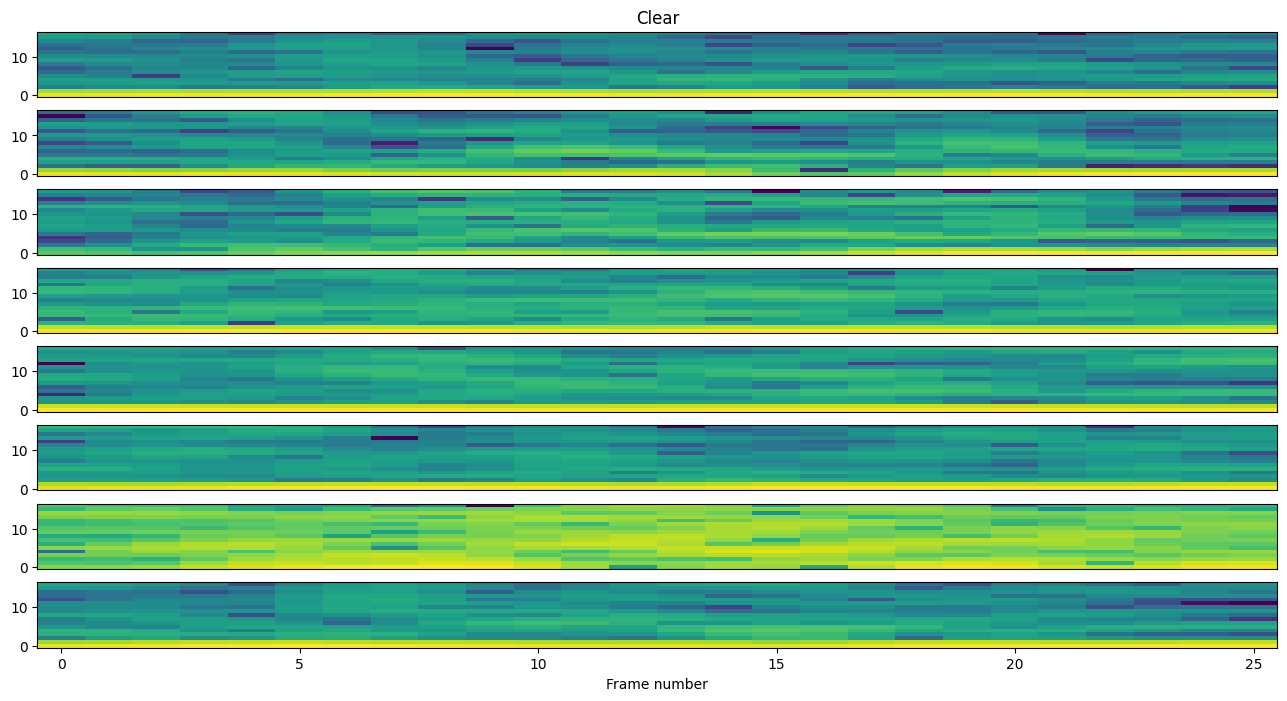

In [11]:
compute_spectrogram(signal, title)

##ACTION-NET-Classifiers

##Unimodal: EMG and RGB

modality="['EMG']",\
split=SXY-SXY,\
models.EMG.model=LSTM_EMG or MLP_EMG or CNN_EMG\
//////////////////////////////////\
 modality="['RGB']" , \
 split=S04-S04,  \
 models.RGB.model=LSTM or MLP


In [ ]:
%%bash

cd aml23-ego

python train_classifier_emg.py\
  config=configs/default.yaml\
  action=train\
  name=CNN_EMG_04dropout_NormalizeFalse\
  modality="['EMG']"\
  feat_avg=False\
  fusion_modalities=False\
  train.num_clips=10\
  train.dense_sampling.RGB=True\
  train.dense_sampling.EMG=True\
  train.num_frames_per_clip.RGB=25\
  train.num_frames_per_clip.EMG=25\
  test.num_clips=10\
  test.dense_sampling.RGB=True\
  test.dense_sampling.EMG=True\
  test.num_frames_per_clip.RGB=25\
  test.num_frames_per_clip.EMG=25\
  dataset.annotations_path=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  dataset.shift=SXY-SXY\
  dataset.RGB.features_name=/content/drive/MyDrive/AML/AML_Project_2024/saved_features/Action-Net-RGB/ActionNet_saved_feat_I3D_10clips_25frames_Dense_05dropout_NormalizeFalse_10sec-actions_myo-right-timestamps\
  dataset.RGB.data_path=data/Action-Net-RGB\
  dataset.EMG.data_path=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  dataset.EMG.features_name=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  models.RGB.model=MLP\
  models.RGB.dropout=0.4\
  models.RGB.normalize=False\
  models.EMG.model=CNN_EMG\
  models.EMG.dropout=0.2\
  models.EMG.normalize=False\
  models.FUSION.model=FUSION_net\
  models.FUSION.dropout=0.2\
  models.FUSION.normalize=False\

In [24]:
#save the Experiment_logs
!cp "/content/aml23-ego/Experiment_logs/CNN_EMG_04dropout_NormalizeFalse/Jun10_12-30-03" -r "/content/drive/MyDrive/AML/AML_Project_2024/saved_models/Action-Net/Unimodal_EMG/"

Unimodal EMG_Spectrograms_CONV2D

##Multimodal classifier: EMG + RGB

modality:["RGB", "EMG"]\
dataset.shift=S04-S04\
models.RGB.model=MLP or LSTM \
models.EMG.model=LSTM_EMG or MLP_EMG or CNN_EMG\
fusion_modalities:True (late feature fusion) or False (logits sum)

In [ ]:
%%bash

cd aml23-ego

python train_classifier_emg.py\
  config=configs/default.yaml\
  action=train\
  name=MLP_EMG_04dropout_NormalizeFalse_LSTM_RGB_04dropout_NormalizeFalse_10clip_25frames_dense_LOGITS_SUM\
  modality="['EMG','RGB']"\
  feat_avg=False\
  fusion_modalities=True\
  train.num_clips=10\
  train.dense_sampling.RGB=True\
  train.num_frames_per_clip.RGB=25\
  test.num_clips=10\
  test.dense_sampling.RGB=True\
  test.num_frames_per_clip.RGB=25\
  dataset.annotations_path=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  dataset.shift=S04-S04\
  dataset.RGB.features_name=/content/drive/MyDrive/AML/AML_Project_2024/saved_features/Action-Net-RGB/ActionNet_saved_feat_I3D_10clips_25frames_Dense_05dropout_NormalizeFalse_10sec-actions_myo-right-timestamps\
  dataset.RGB.data_path=data/Action-Net-RGB \
  dataset.EMG.data_path=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  dataset.EMG.features_name=/content/drive/MyDrive/AML/AML_Project_2024/data/Action-Net/\
  models.RGB.model=MLP\
  models.RGB.dropout=0.4\
  models.RGB.normalize=False\
  models.EMG.model=LSTM_EMG\
  models.EMG.dropout=0.4\
  models.EMG.normalize=False\
  models.FUSION.model=FUSION_net\
  models.FUSION.dropout=0.2\
  models.FUSION.normalize=False\

In [ ]:
!cp "/content/aml23-ego/saved_models/MLP_EMG_04dropout_NormalizeFalse_LSTM_RGB_04dropout_NormalizeFalse_10clip_25frames_dense_LOGITS_SUM/May27_16-41-08/MLP_EMG_04dropout_NormalizeFalse_LSTM_RGB_04dropout_NormalizeFalse_10clip_25frames_dense_LOGITS_SUM" -r "/content/drive/MyDrive/AML/AML_Project_2024/saved_models/Action-Net/Multimodal_EMG/"